<a href="https://colab.research.google.com/github/megz2020/boston_housing/blob/master/Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Spam Classification

## Getting Started
In this project, you will employ several Machine learning algorithms  to accurately model classify messages as spam or not spam using a collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site.

 The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#)
 The datset was donated by  Min-Yen Kan and his team 

In [4]:
# dawnload dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2018-11-08 17:06:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/zip]
Saving to: ‘smsspamcollection.zip.1’

smsspamcollection.z 100%[===================>] 198.65K   983KB/s    in 0.2s    

2018-11-08 17:06:22 (983 KB/s) - ‘smsspamcollection.zip.1’ saved [203415/203415]



In [5]:
!unzip smsspamcollection.zip

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SMSSpamCollection       
replace readme? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: readme                  


# Exploring the Data



In [7]:
!python -m pip install wordcloud


    100% |████████████████████████████████| 368kB 6.9MB/s 


In [0]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score

# Pretty display for notebooks
%matplotlib inline

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib



In [11]:
#Load dataset
pd.set_option('display.max_colwidth', 100)

data = pd.read_csv("SMSSpamCollection", sep='\t', header=None)
data.columns = ['label', 'body_text']

display(data.head())

,label,body_text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [12]:
display(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label        5572 non-null object
body_text    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


None

# Implementation: Data Exploration

A cursory investigation of the dataset will determine how many sms fit into either group, and will tell us about the percentage of these sms which are spam. 


In [13]:
# Total number of records
n_records = data.shape[0]


# Number of records where SMS  are ham
n_ham = data[data.label=="ham"].label.count()

# Number of records where SMS are ham
n_spam =data[data.label=="spam"].label.count()

# Percentage of SMS which are ham
spam_percent = (n_spam / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("SMS which are ham: {}".format(n_ham))
print("SMS which are spam: {}".format(n_spam))
print("Percentage of SMS which are spam : {:.3f}%".format(spam_percent))

Total number of records: 5572
SMS which are ham: 4825
SMS which are spam: 747
Percentage of SMS which are spam : 13.406%


# Cleaning data

In [0]:
# Remove punctuation
import string

def remove_punct(text):
  text_nopunct = "".join([char for char in text if char not in string.punctuation]) 
  return text_nopunct.lower()


In [15]:
data['body_text_clean'] = data['body_text'].apply(lambda x: remove_punct(x))
display(data.head())

,label,body_text,body_text_clean
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though


In [0]:

def wc_message(df, type):
    """
     Visualization repeated words in the messages (spam or ham)!

     inputs:
      - data fram
      - label: type of messages (spam or ham) 
    """
    wc = WordCloud(width = 512, height = 512)
    try:
        if type == 'spam':
            spam_words = ''.join(list(data[data['label'] == 'spam']['body_text_clean'] ))
            spam_wc = wc.generate(spam_words)
            pl.figure(figsize= (10,8), facecolor= 'k')
            pl.imshow(spam_wc)

        elif type == 'ham':
            ham_words = ''.join(list(data[data['label'] == 'ham']['body_text_clean'] ))
            ham_wc = wc.generate(ham_words)
            pl.figure(figsize= (10,8), facecolor= 'k')
            pl.imshow(ham_wc)
        else:
          print("please input right parmeters type wc_message.__doc__ and follow the inputs")



        pl.axis('off')
        pl.tight_layout(pad = 0)
        pl.show()
    except Exception as e:
        print(e)


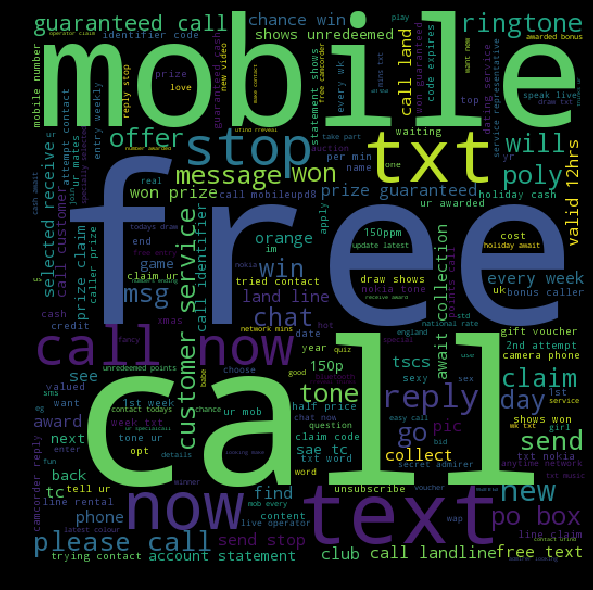

In [17]:
wc_message(data, 'spam')

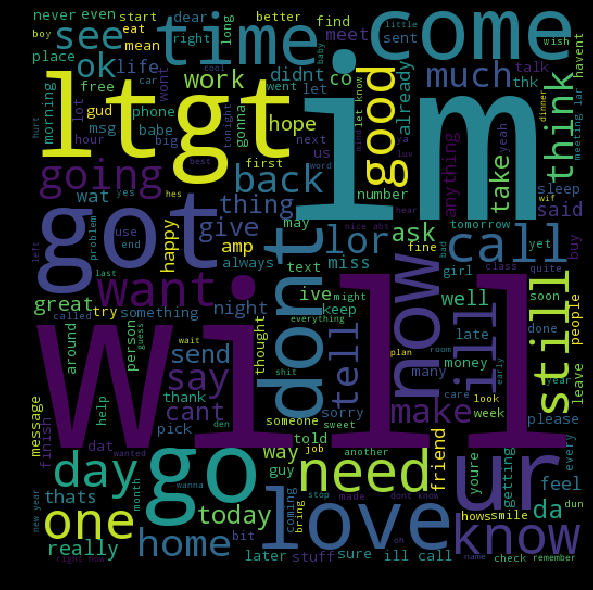

In [18]:
wc_message(data, 'ham')

## install spacy to use it in extract features from text 
* i didnot find english model so i will install it

In [19]:
!pip install -U spacy
import spacy


Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.0.16)
    100% |████████████████████████████████| 13.9MB 2.5MB/s 
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [20]:
!python -m spacy info en 


    Can't find model meta.json
    /usr/local/lib/python3.6/dist-packages/spacy/data/en/meta.json



In [21]:
!python3 -m spacy download en

    100% |████████████████████████████████| 37.4MB 79.9MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [0]:
nlp = spacy.load('en', tagger=False, parser=False, matcher=False)
def toknize(text):
  tokens = nlp(text)    
  return tokens.text.split(" ")
  


In [23]:
data['tokens'] = data['body_text_clean'].apply(lambda x: toknize(x))
display(data.head())

,label,body_text,body_text_clean,tokens
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, then, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]"


In [24]:
# Remove English stop words 
from spacy.lang.en.stop_words import STOP_WORDS

print(STOP_WORDS) 
# you can add new stop words with this command 
#STOP_WORDS.add("your_additional_stop_word_here")

{'formerly', 'became', 'empty', 'how', 'thence', 'first', 'ever', 'put', 'besides', 'several', 'sometimes', 'if', 'these', 'any', 'somehow', 'whereupon', 'yourself', 'ours', 'itself', 'eight', 'everyone', 'per', 're', 'where', 'against', 'amongst', 'beside', 'take', 'above', 'your', 'whenever', 'him', 'other', 'latter', 'others', 'sometime', 'part', 'whither', 'she', 'full', 'been', 'mostly', 'top', 'six', 'wherever', 'himself', 'or', 'but', 'same', 'even', 'seem', 'only', 'front', 'twelve', 'over', 'onto', 'by', 'made', 'is', 'yours', 'since', 'really', 'her', 'still', 'due', 'few', 'namely', 'three', 'using', 'on', 'see', 'make', 'four', 'fifty', 'perhaps', 'that', 'doing', 'as', 'nine', 'thereby', 'every', 'therefore', 'does', 'will', 'you', 'done', 'between', 'in', 'our', 'should', 'had', 'have', 'anyone', 'least', 'us', 'either', 'i', 'seeming', 'whole', 'sixty', 'were', 'herein', 'show', 'why', 'those', 'under', 'what', 'twenty', 'whatever', 'here', 'out', 'throughout', 'nowhere'

In [0]:
def remove_stopwords(tokenized_list):
  text = [word for word in tokenized_list if word not in STOP_WORDS]
  return text

In [26]:
data['text_nostop'] = data['tokens'].apply(lambda x: remove_stopwords(x))

data.head()

,label,body_text,body_text_clean,tokens,text_nostop
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, 2005, text, fa, 87121, receive, en..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, then, say]","[u, dun, early, hor, u, c]"
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives]"


In [27]:
from spacy import displacy

doc = nlp(data.body_text_clean[0])
displacy.render(doc, style='dep', jupyter=True)


### Lemmatize *text*

In [0]:
def lemmatizing(tokenized_text):
    doc = str(tokenized_text).replace('[','').replace(']','')
    doc = nlp(doc)
    text = [token.lemma_ for token in doc]
    text = [w for w in text if w.isalpha() or w.isdigit()]

    return text

In [31]:
data['text_lemmatized'] = data['text_nostop'].apply(lambda x: lemmatizing(x))

data.head(5)

,label,body_text,body_text_clean,tokens,text_nostop,text_lemmatized
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, 2005, text, fa, 87121, receive, en...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 2005, text, fa, 87121, receive, entry, q..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, then, say]","[u, dun, early, hor, u, c]","[u, dun, early, hor, u, c]"
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives]","[nah, do, not, think, go, usf, live]"


# Create the two new features

In [32]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))
data.head()

,label,body_text,body_text_clean,tokens,text_nostop,text_lemmatized,body_len,punct%
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]",92,9.8
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, 2005, text, fa, 87121, receive, en...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 2005, text, fa, 87121, receive, entry, q...",128,4.7
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, then, say]","[u, dun, early, hor, u, c]","[u, dun, early, hor, u, c]",39,15.4
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives]","[nah, do, not, think, go, usf, live]",49,4.1


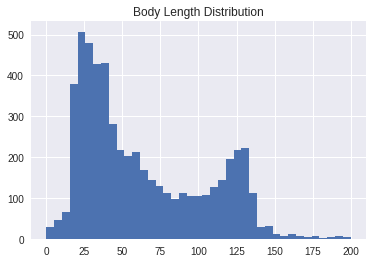

In [33]:
bins = np.linspace(0, 200, 40)

pl.hist(data['body_len'], bins)
pl.title("Body Length Distribution")
pl.show()

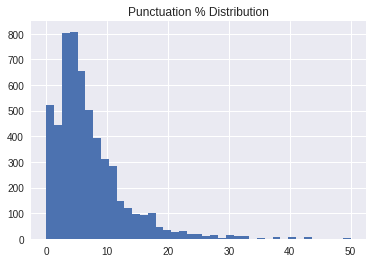

In [34]:
bins = np.linspace(0, 50, 40)

pl.hist(data['punct%'], bins)
pl.title("Punctuation % Distribution")
pl.show()

In [35]:
display(data.head(2))

,label,body_text,body_text_clean,tokens,text_nostop,text_lemmatized,body_len,punct%
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]",92,9.8
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",24,25.0


# Normalizing Numerical Features


In [36]:
# preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['body_len', 'punct%']

data[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(data.head(n = 5))

,label,body_text,body_text_clean,tokens,text_nostop,text_lemmatized,body_len,punct%
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]",0.121951,0.098
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",0.029810,0.250
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, 2005, text, fa, 87121, receive, en...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 2005, text, fa, 87121, receive, entry, q...",0.170732,0.047
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, then, say]","[u, dun, early, hor, u, c]","[u, dun, early, hor, u, c]",0.050136,0.154
4,ham,"Nah I don't think he goes to usf, he lives around here though",nah i dont think he goes to usf he lives around here though,"[nah, i, dont, think, he, goes, to, usf, he, lives, around, here, though]","[nah, dont, think, goes, usf, lives]","[nah, do, not, think, go, usf, live]",0.063686,0.041


In [37]:
# save data after normlize it in pkl file to use it latter 
joblib.dump(scaler, 'scalr.pkl')


['scalr.pkl']

In [0]:
# convert label to number before aplly ML algorithms
label_map = {'spam': 1, 'ham': 0}
data['label'] = data['label'].map(label_map)

In [39]:
display(data.head(3))

,label,body_text,body_text_clean,tokens,text_nostop,text_lemmatized,body_len,punct%
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, ci...","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]",0.121951,0.098
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",0.029810,0.250
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...,"[free, entry, in, 2, a, wkly, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, text, fa, to...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 21st, 2005, text, fa, 87121, receive, en...","[free, entry, 2, wkly, comp, win, fa, cup, final, tkts, 2005, text, fa, 87121, receive, entry, q...",0.170732,0.047


# Shuffle and Split Data

Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.




In [0]:
features_final = data[['text_lemmatized', 'body_len', 'punct%']]
label = data['label']

In [41]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    label, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4457 samples.
Testing set has 1115 samples.


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Vectorize text

In [0]:
# conver 'text_lemmatized' col from list to string to apply TfidfVectorizer on it
def tostring(text):
  doc = str(text).replace('[','').replace(']','')
  return doc

  

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vect = TfidfVectorizer(analyzer = tostring)
tfidf_vect_fit = tfidf_vect.fit(X_train['text_lemmatized'])

tfidf_train = tfidf_vect_fit.transform(X_train['text_lemmatized'])
tfidf_test = tfidf_vect_fit.transform(X_test['text_lemmatized'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

display(X_train_vect.head())

,body_len,punct%,0,1,2,3,4,5,6,7,...,34,35,36,37,38,39,40,41,42,43
0,0.060976,0.064,0.292927,0.685271,0.292927,0.00000,0.0,0.0,0.000000,0.0,...,0.253111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.078591,0.033,0.281952,0.641275,0.281952,0.00000,0.0,0.0,0.000000,0.0,...,0.000000,0.078569,0.0,0.073026,0.0,0.0,0.0,0.0,0.0,0.0
2,0.073171,0.089,0.286581,0.670427,0.286581,0.17959,0.0,0.0,0.204484,0.0,...,0.000000,0.000000,0.0,0.089070,0.0,0.0,0.0,0.0,0.0,0.0
3,0.043360,0.059,0.257121,0.668343,0.257121,0.00000,0.0,0.0,0.000000,0.0,...,0.000000,0.143299,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.032520,0.115,0.000000,0.605601,0.000000,0.00000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.482744,0.0,0.0,0.0,0.0,0.0,0.0


# save my vectorize text in pkl file to use it later without make previous step

In [44]:
from sklearn.externals import joblib

joblib.dump(tfidf_vect, 'vectroizer.pkl')

['vectroizer.pkl']

# Evaluating Model Performance


I will investigate  different algorithms, and determine which is best at modeling the data.

## Metrics and the Naive Predictor





 Because of *Digisay* is particularly interested in predicting which links related to R7eem  accurately. It would seem that using accuracy as a metric for evaluating a particular model's performace would be appropriate. Therefore, a model's ability to precisely predict those which related to R7eem is more important than the model's ability to recall those not related. We can use F-beta score as a metric that considers both precision and recall:


$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$
In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the <strong>F$_{0.5}$ score (or F-score for simplicity).

It is always important to consider the naive prediction for your data, to help establish a benchmark for whether a model is performing well. using that prediction would be pointless: If we predicted all links not related , ML model would identify no linke as related.

In [45]:
'''
TP = np.sum(label) # Counting the ones as this is the naive case. 
FP = label.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''

# Calculate ones in income (True postive) and zeroes 
TP = np.sum(label)
FP = label.count() - TP 
TN = 0
FN = 0

# TODO: Calculate accuracy, precision and recall
accuracy = TP /(TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2)*((precision * recall) / ((beta**2 * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.1341, F-score: 0.1621]


# Supervised Learning Models


**The following are some of the supervised learning models that are currently available in scikit-learn that i will use:**



**Gaussian Naive Bayes**

* A classical use case is document classification: Determining whether a given (text) document corresponds to one or more categories and for classifying and filtering spam emails based on the likelihood of certain words appearing on an spam email as compared to a non-spam email

* Strengths:

 * Easy to implement , Simple to run
 * If the NB conditional independence assumption holds, then it will converge quicker than discriminative models like logistic regression
 * Even if the NB assumption doesn’t hold, it works great in practice.
 * Less training data than others
 * Can be used for both binary and mult-iclass classification problems.
 * Performs pretty well
* Weaknesses:

 * It can’t learn interactions between features (e.g., it can’t learn that although you love movies with Brad Pitt and Tom Cruise, you hate movies where they’re together).
 * Data scarcity For any possible value of a feature, you need to estimate a likelihood value by a frequentist approach. This can result in probabilities going towards 0 or 1, which in turn leads to numerical instabilities and worse results. In this case, you need to smooth in some way your probabilities (e.g. as in sklearn), or to impose some prior on your data, however you may argue that the resulting classifier is not naive anymore.
* This particular model could be a good approach to solving the problem as we have a large data set with few features.

* References:
 * [wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering)
 * [quora - real world applications for Naive Bayes classifier](https://www.quora.com/In-what-real-world-applications-is-Naive-Bayes-classifier-used)
 * [youtube- udacity - Naive Bayes Strengths and Weaknesses](https://www.youtube.com/watch?v=nfbKTrufPOs)
 * [quora - the advantages of using a naive Bayes for classification](https://www.quora.com/What-are-the-advantages-of-using-a-naive-Bayes-for-classification)
 * [quora - disadvantages of using a naive bayes for classification](https://www.quora.com/What-are-the-disadvantages-of-using-a-naive-bayes-for-classification#ypRbo)





**AdaBoost:**
* A classic use case where AdaBoost algorithms is in the problem of Face Detection.

* Strengths:

 * AdaBoost very simple to implement we can achieve similar classification results with much less tweaking of parameters or settings The user only needs to choose:

   1. which weak classifier might work best to solve their given classification problem.
   2. the number of boosting rounds that should be used during the training phase.
   
 * Feature selection on very large sets of features.

* Weaknesses

 * AdaBoost can be sensitive to noisy data and outliers. In some problems, however, it can be less susceptible to the overfitting problem than most learning algorithms. AdaBoost algorithm does not currently support null rejection, although this will be added at some point in the near future.
 * This particular model could be a good approach to solving the problem as we have a large data set so we can we can perform multiple quick trainining iterations to maximize our overall accuracy.

* References:
 * [analyticsvidhya](https://www.analyticsvidhya.com/blog/2015/05/boosting-algorithms-simplified/)
 * [nickgillian](http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost)
 * [slideshare - Machine learning with ADA Boost](https://www.slideshare.net/aman3001/machine-learning-with-ada-boost)

**Support Vector Machines (SVC)**

* SVMs can be used to solve various real world problems:

 * SVMs are helpful in text and hypertext categorization as their application can significantly reduce the need for labeled training instances in both the standard inductive and transductive settings.
 * Face Detection.
   * It classifies the parts of the image as face and non-face. It contains training data of n x n pixels with a two-class face (+1) and non-face (-1). Then it extracts features from each pixel as face or non-face. Creates a square boundary around faces on the basis of pixel brightness and classifies each image by using the same process.
 * Classification of images.
   * Experimental results show that SVMs achieve significantly higher search accuracy than traditional query refinement schemes after just three to four rounds of relevance feedback.
 * Hand-written characters can be recognized
 Bioinformatics.

* Strengths:

 * High accuracy
 * Nice theoretical guarantees regarding overfitting
 * With an appropriate kernel they can work well even if you’re data isn’t linearly separable in the base feature space.
* Weaknesses:

 * Don't perform so well in very large data set because the training time happens to be cubic in size of data set.
 * Don't work very well in lots and lots of noise do when class are very overlapping you have to count independent evidence that's where the naive bayes classifier would be better.
 * The theory only really covers the determination of the parameters for a given value of the regularisation and kernel parameters and choice of kernel. In a way the SVM moves the problem of over-fitting from optimising the parameters to model selection. Sadly kernel models can be quite sensitive to over-fitting the model selection criterion.
 * The model could be still be a good candidate as there seems to be some features in the data that can more clearly define the income level boundary and dataset not very large so it won't take so long training time

* References:
 * [wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#Applications)
 * [data-flair - Real-Life Applications of SVM](https://data-flair.training/blogs/applications-of-svm/)
 * [blog.echen.me](http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/)
 * [youtube - udacity - SVM Strengths and Weaknesses](https://www.youtube.com/watch?v=U9-ZsbaaGAs)
 * [stackexchange - Advantages and disadvantages of SVM](https://stats.stackexchange.com/questions/24437/advantages-and-disadvantages-of-svm)

# Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important to create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.  In the code block below, i will  implement the following:

* Import fbeta_score and accuracy_score from sklearn.metrics.
* Fit the learner to the sampled training data and record the training time.
* Perform predictions on the test data X_test, and also on the first 300    training points X_train[:300].
* Record the total prediction time.
* Calculate the accuracy score for both the training subset and testing set.
* Calculate the F-score for both the training subset and testing set.


In [0]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score , accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: label training set
       - X_test: features testing set
       - y_test: label testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[: sample_size], y_train[: sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

# Implementation: Initial Model Evaluation

In the code cell, i will  implement the following:

* Import the three supervised learning models i've discussed in the previous section.
* Initialize the three models and store them in 'clf_A', 'clf_B', and 'clf_C'.
* Use a 'random_state' for each model i use.
* Calculate the number of records equal to 1%, 10%, and 100% of the training data.
* Store those values in 'samples_1', 'samples_10', and 'samples_100' respectively.


In [0]:
#visualization

def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 4, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Set additional plots invisibles
    ax[0, 3].set_visible(False)
    ax[1, 3].axis('off')

    # Create legend
    for i, learner in enumerate(results.keys()):
        pl.bar(0, 0, color=colors[i], label=learner)
    pl.legend()
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


GaussianNB trained on 44 samples.
GaussianNB trained on 445 samples.
GaussianNB trained on 4457 samples.
AdaBoostClassifier trained on 44 samples.
AdaBoostClassifier trained on 445 samples.
AdaBoostClassifier trained on 4457 samples.
SVC trained on 44 samples.
SVC trained on 445 samples.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 4457 samples.


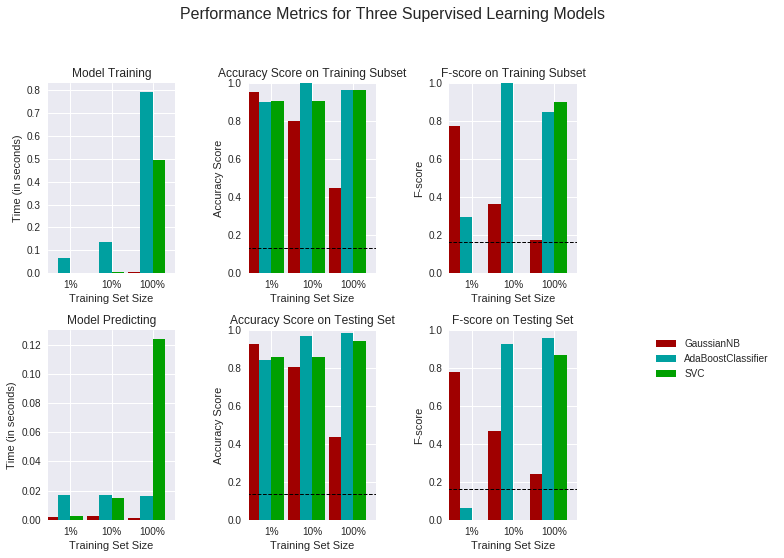

In [48]:
# Import the  supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from time import time
import matplotlib.pyplot as pl

# Initialize the three models
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state = 1)
clf_C = SVC(random_state = 1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = len(y_train)//10
samples_1 = len(y_train)//100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train_vect, y_train, X_test_vect, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

# Choosing the Best Model
- The most appropriate solution to this problem would be achieved using AdaBoostClassifier .
 - In terms of the F-score, Adaboost slightly outperforms SVC at all training set sizes and significately outperforms GaussianNB.
 - In terms of the time Both the Adaboost and the GaussianNB algorithms are capable of both training on the entire data set and quickly performing predictions.
 - In terms of the accuracies at all training and testing set sizes Adaboost are significantly higher than those obtained when using the GuassianNB algorithm and as high as those ahieved by the more complex SVC model.
- For this reasons we can say that Adaboost is best suited for this problem. We will be able to fully utilize the entire dataset to maximize the performance in the unseen data without compromising on training and testing the speeds.and will give us accurate result for spam message

# Implementation: Model Tuning


In [49]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(random_state=1)

parameters = {'n_estimators' : [50, 100, 150, 250, 500], 'learning_rate': [0.01, 0.1, 1, 1.5, 2]}

# Make an fbeta_score scoring object using make_scorer()
scorer =make_scorer(fbeta_score, beta= 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_vect, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train_vect, y_train)).predict(X_test_vect)
best_predictions = best_clf.predict(X_test_vect)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.9821
F-score on testing data: 0.9574

Optimized Model
------
Final accuracy score on the testing data: 0.9785
Final F-score on the testing data: 0.9583


In [55]:
display(grid_fit.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=1)

# Implementation


In [59]:
#Train the model on the training set using .fit(X_train_vect, y_train)
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=1)
start = time()
model.fit(X_train_vect, y_train)
end = time()
fit_time = (end - start)
start = time()
y_pred = model.predict(X_test_vect)
end = time()
pred_time = (end - start)

recision, recall, fscore, train_support = score(y_test, y_pred)
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    np.round(fit_time, 3), np.round(pred_time, 3), np.round(precision, 3), np.round(recall, 3), np.round((y_pred==y_test).sum()/len(y_pred), 3)))


Fit time: 1.469 / Predict time: 0.022 ---- Precision: 0.134 / Recall: [0.998 0.862] / Accuracy: 0.978


# Save model

In [60]:
# Save to file in the current working directory
joblib_file = "joblib_model.pkl"  
joblib.dump(model, joblib_file)


['joblib_model.pkl']

# Test model

In [61]:
joblib_file = "joblib_model.pkl"  

joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test_vect, y_test)  
print("Test score: {0:.2f} %".format(100 * score))  
Ypredict = joblib_model.predict(X_test_vect)  


Test score: 97.85 %


# Now we will test new data

In [0]:
def prep_text(mesg):
  text = remove_punct(mesg)
  data = pd.DataFrame({'body_text' : text}, index=[0])
  data['tokens'] = data['body_text'].apply(lambda x: toknize(x))
  data['text_nostop'] = data['tokens'].apply(lambda x: remove_stopwords(x))
  data['text_lemmatized'] = data['text_nostop'].apply(lambda x: lemmatizing(x))
  data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
  data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))
  return data
  
  
  

In [0]:
# ham msg
msg = """As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune"""

In [64]:
data_prep = prep_text(msg)
display(data_prep)

,body_text,tokens,text_nostop,text_lemmatized,body_len,punct%
0,as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertu...,"[as, per, your, request, melle, melle, oru, minnaminunginte, nurungu, vettam, has, been, set, as...","[request, melle, melle, oru, minnaminunginte, nurungu, vettam, set, callertune, callers, press, ...","[request, melle, melle, oru, minnaminunginte, nurungu, vettam, set, callertune, caller, press, 9...",129,0.0


In [65]:
file = 'scalr.pkl'
scaler = joblib.load(file) 
numerical = ['body_len',  'punct%']
data_prep[numerical] = scaler.transform(data_prep[numerical])

display(data_prep)

,body_text,tokens,text_nostop,text_lemmatized,body_len,punct%
0,as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertu...,"[as, per, your, request, melle, melle, oru, minnaminunginte, nurungu, vettam, has, been, set, as...","[request, melle, melle, oru, minnaminunginte, nurungu, vettam, set, callertune, callers, press, ...","[request, melle, melle, oru, minnaminunginte, nurungu, vettam, set, callertune, caller, press, 9...",0.172087,0.0


In [66]:
vectorizer = joblib.load('vectroizer.pkl')
tfidf_msg_pred = vectorizer.transform(data_prep['text_lemmatized'])
X_pred_vect = pd.concat([data_prep[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_msg_pred.toarray())], axis=1)

display(X_pred_vect.head())


,body_len,punct%,0,1,2,3,4,5,6,7,...,34,35,36,37,38,39,40,41,42,43
0,0.172087,0.0,0.285861,0.597092,0.285861,0.0,0.0,0.0,0.0,0.0,...,0.044108,0.0,0.0,0.031731,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
try:
    Ypredict = joblib_model.predict(X_pred_vect)
    if Ypredict[0] == 0:
       print("msg is ham")
    elif Ypredict[0] == 1:
        print("msg is spam")
except Exception as e:
  print(e)


msg is ham


#Embedded this model in flask app

- i will embedded this model in flask app in few days and i'll put code in my github

# conclusion
As we see we have messy data so we try to make it tidy as possible to make it suitable for ML algorithms
- i use spacy which an open-source software library for advanced Natural Language Processing to split text in to words .
- then convert this words to numbers
- i try some algorithms and choose the best one
- AdaBoost is short for Adaptive Boosting. It is basically a machine learning algorithm that is used as a classifier. Whenever you have a large amount of data and you want divide it into different categories, we need a good classification algorithm to do it. Problems in machine learning tend to suffer from the curse of dimensionality. What it means is that a single feature point ends up having a huge dimensionality. As in, the feature vector used to describe a particular thing can be very huge. So if each sample consists of a huge number of potential features, the overall system becomes very slow. This is the reason we cannot use a powerful model with a full feature set because it cannot run in real time. We can only afford to have simple machine learning algorithms. But if the algorithms are too simple, they tend to be less accurate. They are called ‘weak learners’

- Boosting algorithms typically work by solving subsections of the problem, by peeling them away so future boosting iterations can solve the remaining sections.

- imagine we have some questions in different fields(math, physics , chemistry)i ask my friend who proficient in math to answer this questions after he answer i'm sure he answer math questions very well but i'm not sure about other questions so we go to another friend who proficient in physics and ask him to answer the questions like before i'm sure he answer physics questions very well but i'm not sure about other questions but now i have one can give me right answer for math questions and one who can give me right answer for physics questions this is better than before. now i want one who is proficient in chemistryfor our luck my friend's brother is thr right guy so i ask him to answer the questions so now each group of my questions is completely solved.
- The takeaway is that weak learners are best combined in a way that allows each one to solve a limited section of the problem. Any machine learning routine can be used as a weak learner. Neural nets, support vector machines or any other would work, but the most commonly used weak learner is the decision tree.
- so in our model it combines the outputs from weak learner and creates a strong learner which eventually improves the prediction power of the model. Boosting pays higher focus on examples which are mis-classiﬁed or have higher errors by preceding weak rules.



